[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorial_notebooks/6_classification_solutions.ipynb) 

# Tutorial 6 - Classification for Credit Risk Prediction

<span style="font-weight: bold; color: red;">This version includes solutions to the exercises. </span>

In this demo notebook, we will revisit our lecture on classification models. To that end, we consider the logistic regression model and study how it allows us to approach a probability-to-default prediction task. The notebook comprises ready-to-use demo codes and small programming tasks. 

## Preliminaries
Before moving on, let's import some of our standard library so that we have them ready when we need them.


In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### The HMEQ data set
We continue using the "Home Equity" data set (HMEQ), which was introduced in your [last session](https://github.com/Humboldt-WI/bads/blob/master/tutorial_notebooks/5_data_prep_tasks.ipynb).
To keep this notebook self-contained, we re-introduce the set of features below: 

- BAD: the target variable, 1=default; 0=non-default 
- LOAN: amount of the loan request
- MORTDUE: amount due on an existing mortgage
- VALUE: value of current property
- REASON: DebtCon=debt consolidation; HomeImp=home improvement
- JOB: occupational categories
- YOJ: years at present job
- DEROG: number of major derogatory reports
- DELINQ: number of delinquent credit lines
- CLAGE: age of oldest credit line in months
- NINQ: number of recent credit inquiries
- CLNO: number of credit lines
- DEBTINC: debt-to-income ratio

As you can see, the features aim at describing the financial situation of a borrower. We will keep using the data set for many modeling tasks in this and future notebooks. So it makes sense to familiarize yourself with the above features. Make sure you understand what type of information they provide and what this information might reveal about the risk of defaulting.  

### Pandas reloaded
You have already seen the Pandas library in action. We assume you have familiarized yourself with the demos and exercises of [Tutorial 5](https://github.com/Humboldt-WI/bads/blob/master/tutorial_notebooks/5_data_prep_tasks.ipynb). Below, we load the data and revisit some standard operations to eyeball the data.

In [2]:
# Load the data directly from GitHub
data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq.csv'
df = pd.read_csv(data_url)

# To show that everything worked out, we can print the first few rows of the data frame
df

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


In [3]:
# Obtain a more technical overview of the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


The above output displays some useful information how exactly data is stored. We learn about the data type of each feature (i.e, each *data series* object), missing values, and the total amount of memory that the data consumes.

In [4]:
# Produce summary statistics (to R-programmers: this is equivalent to the famous R function summary())
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


### Preparing the data for analysis
The data exhibits several standard data quality issues including missing values. We discussed in previous tutorials and exercises to address such issues and prepare the data for analysis. Take a little time to review the following codes. They do not comprise novel concepts. Rather, we combine known programming steps to ready our data for classification modeling. 

#### Altering data types
See [Tutorial 5](https://github.com/Humboldt-WI/bads/blob/master/tutorial_notebooks/5_data_prep_tasks.ipynb) for details. 

In [5]:
# The target variable has only two states so that we can store it as a boolean
df['BAD'] = df['BAD'].astype('bool')

# Code categories properly 
df['REASON'] = df['REASON'].astype('category')
df['JOB'] = df['JOB'].astype('category')

# Verify that the data types have been changed
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   BAD      5960 non-null   bool    
 1   LOAN     5960 non-null   int64   
 2   MORTDUE  5442 non-null   float64 
 3   VALUE    5848 non-null   float64 
 4   REASON   5708 non-null   category
 5   JOB      5681 non-null   category
 6   YOJ      5445 non-null   float64 
 7   DEROG    5252 non-null   float64 
 8   DELINQ   5380 non-null   float64 
 9   CLAGE    5652 non-null   float64 
 10  NINQ     5450 non-null   float64 
 11  CLNO     5738 non-null   float64 
 12  DEBTINC  4693 non-null   float64 
dtypes: bool(1), category(2), float64(9), int64(1)
memory usage: 483.5 KB


#### Missing values
See [Tutorial 5](https://github.com/Humboldt-WI/bads/blob/master/tutorial_notebooks/5_data_prep_tasks.ipynb) for details. 

##### Imputation in categorical features
We replace missing values in categorical features with the most frequent value.

In [6]:
# Get an index of the categorical columns
ix_cat = df.select_dtypes(include=['category']).columns

# Process each category
for c in ix_cat:
    df.loc[df[c].isna(), c ] = df[c].mode()[0]  # the index [0] is necessary as the result of calling mode() is a Pandas Series

# Verify that there are no missing values left
df[ix_cat].isna().sum()


REASON    0
JOB       0
dtype: int64

##### Missing values in numerical features
We use median imputation to replace missing values in numerical features. While we could use a loop, just as before, a more elegant way is to use the `SimpleImputer` class from the `sklearn.impute` module. Recall that [Tutorial 5](https://github.com/Humboldt-WI/bads/blob/master/tutorial_notebooks/5_data_prep_tasks.ipynb) demonstrated further options to achieve the same. It is common that there is no single *best* way of programming things. 

In [7]:
from sklearn.impute import SimpleImputer

# Create an imputer object with the strategy 'median'
imputer = SimpleImputer(strategy='median')

# Select only numerical columns
ix_num = df.select_dtypes(include=np.number).columns

# Apply the imputer to the numerical columns
df[ix_num] = imputer.fit_transform(df[ix_num])

df[ix_num].isna().sum()

LOAN       0
MORTDUE    0
VALUE      0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

#### Outliers
Given that our data includes some outliers, we apply our standard outlier truncation mechanism. This time, we focus on extreme outliers (i.e., 3 times inter-quartile-range above/below the 75th/25th percentile). Further, we exclude two features from outlier treatment: `DEROG` and `DELINQ`. The reason is that standard outlier truncation would completely destroy these features due to their very skewed distribution. We will come back to this point later in the notebook and propose a more suitable treatment for these features. 

We also exclude the `DEBTINC` feature from outlier treatment. This is for didactic reasons. The feature is more informative without standard outlier treatment.  

In [8]:
# Helper function to handle outliers
def truncate_outliers(df, factor=1.5):
    excluded_columns = ['DEROG', 'DELINQ', 'DEBTINC']
    ix_num  = [c for c in df.select_dtypes(include=np.number).columns if c not in excluded_columns]   
    for col in ix_num:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

# Apply the function to the data and inspect the results
df = truncate_outliers(df, factor=3)
df.describe()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000
mean,18459.177852,72326.504060,100527.982473,8.755159,0.224329,0.405705,179.014539,1.148322,21.235906,34.000651
std,10500.744330,39437.327495,50639.354946,7.255089,0.798458,1.079256,80.768529,1.538720,9.901447,7.644528
min,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,11100.000000,48139.000000,66489.500000,3.000000,0.000000,0.000000,117.371430,0.000000,15.000000,30.763159
50%,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,23300.000000,88200.250000,119004.750000,12.000000,0.000000,0.000000,227.143058,2.000000,26.000000,37.949892
max,59900.000000,208384.000000,276550.500000,39.000000,10.000000,15.000000,556.457943,8.000000,59.000000,203.312149


# Explanatory data analysis
Now that we are familiar with Pandas and have prepared out data, at least rudimentary, we can explore some of the plotting capabilities in Python. To that end, we go through an EDA pipeline and try to improve our understanding of the data along the way.
<br>

### Univariate analysis of categorical variables
In this part, we will examine  our target variable 'BAD', as well as the two categorical variables 'REASON' and 'JOB' individually. Firstly, we will count how many observations belong to each category of a variable. The function `value_counts()` is a good choice to process all categories in one go, as follows:

In [9]:
df.select_dtypes(exclude=np.number).apply(pd.Series.value_counts)

,BAD,REASON,JOB
False,4771.0,NaN,NaN
True,1189.0,NaN,NaN
DebtCon,NaN,4180.0,NaN
HomeImp,NaN,1780.0,NaN
Mgr,NaN,NaN,767.0
Office,NaN,NaN,948.0
Other,NaN,NaN,2667.0
ProfExe,NaN,NaN,1276.0
Sales,NaN,NaN,109.0
Self,NaN,NaN,193.0


<br>
While tables are a useful way to inspect data, graphs are often easier to interpret and more appealing. For categories, count plots and stacked count plots are common vehicles for data exploration. 

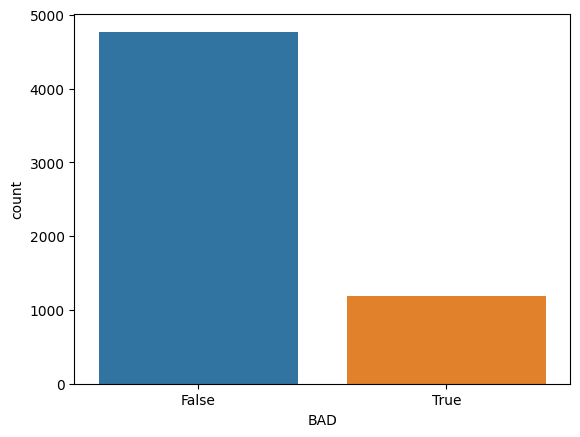

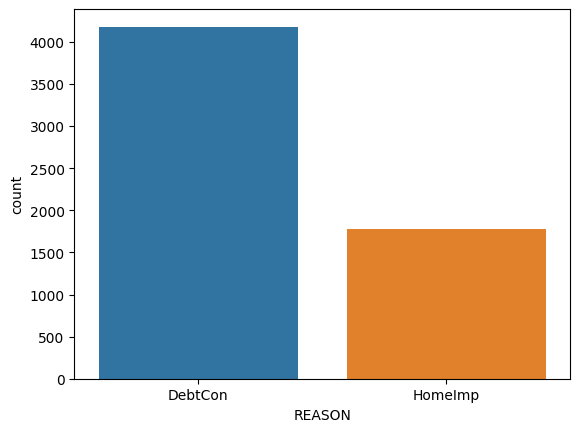

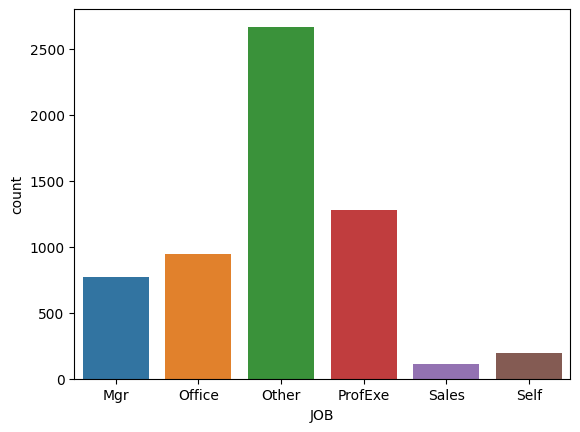

In [10]:
# exluding data type float leaves us with the target variable and both categorical variables
for i, col in enumerate(df.select_dtypes(exclude=np.number).columns):
    plt.figure(i)
    sns.countplot(x=col, data=df)

### Univariate analysis of numeric variables
Let us now take a closer look at the numeric variables and their distribution by means of histograms. Creating a histogram is easily achieved using the `hist()` function, which Pandas offers. Dedicated plotting libraries offer a bit more flexibility. For start, we showcase functionality of the `Seaborn` library. We recommend this version when you examine a single variable at a time.

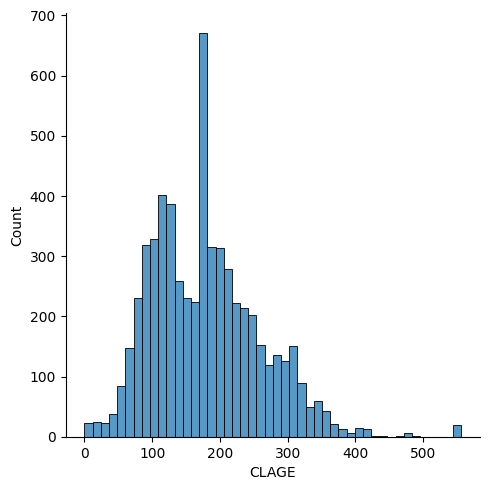

In [11]:
# Demo of a histogram using Seaborn
sns.displot(df['CLAGE']);  # Explore the arguments that the function supports to discober variants of the plot

Next, we consider a basic histogram and use Pandas functionality to produce an overview of all the numeric variables in the data.

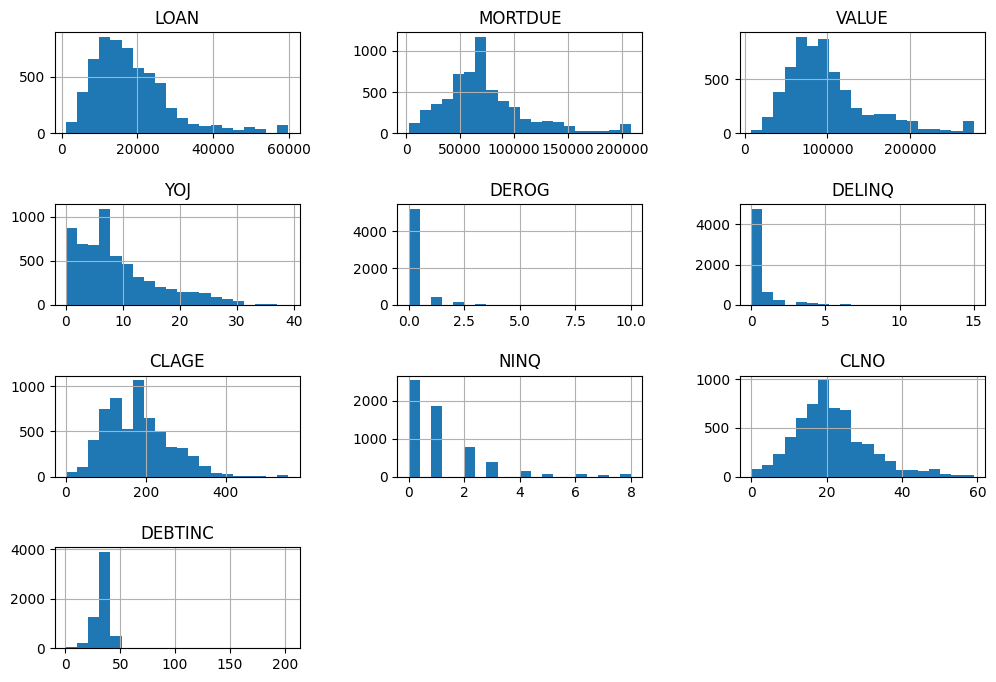

In [12]:
# We create one histogram for each numeric variable and illustrate how to set the number of bins
df.select_dtypes(include=np.number).hist(bins=20, figsize=(12,8))
plt.subplots_adjust(hspace=0.7, wspace=0.4)
plt.show()

Despite our outlier treatment, we stil observe many variables to have a long tail. This is plausible since we only treated extreme outliers above. To emphasize this, let's proceed with the next key plot, the **boxplot**.

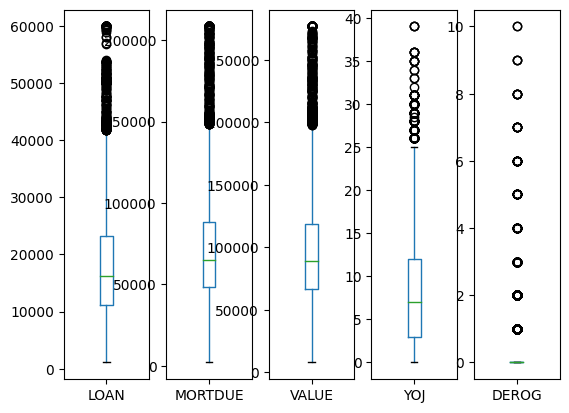

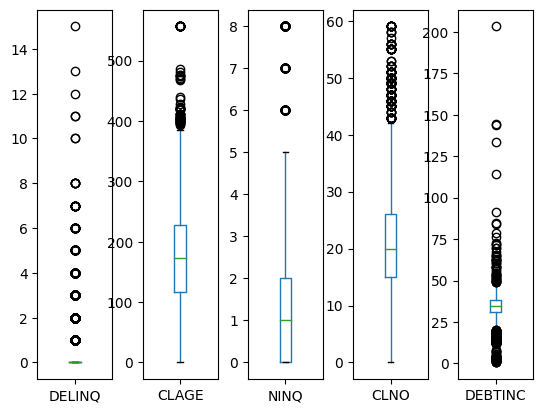

In [13]:
# One boxplot for each variable
ix_num = df.select_dtypes(include=np.number)
half = np.ceil(ix_num.shape[1] / 2).astype(int)  # for cosmetic reasons we split the plots into two rows
ix_num.iloc[:, 0:half].plot(kind = 'box', subplots=True);
ix_num.iloc[:, half:ix_num.shape[1]].plot(kind = 'box', subplots=True)
plt.subplots_adjust(hspace=0.7, wspace=0.4)
plt.show()

#### Discretization of Numeric Variables

As seen in the boxplots above, we are facing some issues with the distribution of `DEROG` and `DELINQ`. Given their distribution, it seems appropriate to discretize these variables.  Discretization is the process of converting a numeric variable into a discrete variable, i.e., a category. Since both, `DEROG` and `DELINQ` display a large number of zeros, we could, for example, consider one category level *isZero* and another *IsGreaterThenZero*. This would give a binary variable. We can also introduce more category levels to obtain a fine-grained categorical representation of the original numbers. Normally, the function `qcut()` is a good choice to discretize a variable based on quantiles. We cannot demonstrate this with `DEROG` and `DELINQ` since their distributions do not warrant using quantiles as split points. Let's first inspect the set of distinct values in these two features.

In [14]:
df.DELINQ.value_counts()

0.0     4759
1.0      654
2.0      250
3.0      129
4.0       78
5.0       38
6.0       27
7.0       13
8.0        5
11.0       2
10.0       2
13.0       1
12.0       1
15.0       1
Name: DELINQ, dtype: int64

In [15]:
df.DEROG.value_counts()

0.0     5235
1.0      435
2.0      160
3.0       58
4.0       23
6.0       15
5.0       15
7.0        8
8.0        6
9.0        3
10.0       2
Name: DEROG, dtype: int64

How you proceed from here is based on judgment. We will exemplify two different techniques that could be considered in the focal case. For one feature, we will create a dummy, indicating whether or not the value of the variable is 0. For the other feature, we will group into three categories. As "DELINQ" shows fewer observations for the value 0, we will use this variable to divide into three groups: 0, 1 & >1. If you wish, this is a manual, or expert-based version of discretization in which we pick the boundaries of the buckets manually instead of picking them by looking at quantiles.  

In [16]:
df['DELINQcat'] = '1+' #set default value to +1 for new variable 
df.loc[(df['DELINQ'] == 1), 'DELINQcat'] = '1' # change this value to 1, if value of DELINQ is 1
df.loc[(df['DELINQ'] == 0), 'DELINQcat'] = '0'
df['DELINQcat'] = df['DELINQcat'].astype('category')  # convert to categorical
df.DELINQcat.value_counts()

0     4759
1      654
1+     547
Name: DELINQcat, dtype: int64

We will proceed similarly with the variable "DEROG". We will create a dummy variable where every observation has the value 1 (true) if their value for the "DEROG" variable was 0. Every other value will be assigned the value 0 (false).

In [17]:
df['DEROGzero'] = 0 #set default to 0
df.loc[(df['DEROG'] == 0), 'DEROGzero'] = 1 #change to 1 if value of "DEROG" is 0 
df['DEROGzero'] = df['DEROGzero'].astype('bool')
df.DEROGzero.value_counts()

True     5235
False     725
Name: DEROGzero, dtype: int64

We are not done with our EDA workflow. However, we will not make any more changes to the data. Therefore, it is a good time to save a copy of the prepared data so that we can re-use it in subsequent coding sessions.

In [18]:
# Store the data in the present, pre-processed format
df.to_csv('./hmeq_prepared.csv', index=False)

### Multivariate analysis of numeric variables

After gaining more knowledge about the variables individually, it is important to examine their relationships more closely. In data science, this is a good way of identifying redundant information as well as variable interactions. 
Next, we will plot a heatmap. It shows the correlation for all numeric variables. Highly correlated variables are redundant as they convey the same pieces of information.

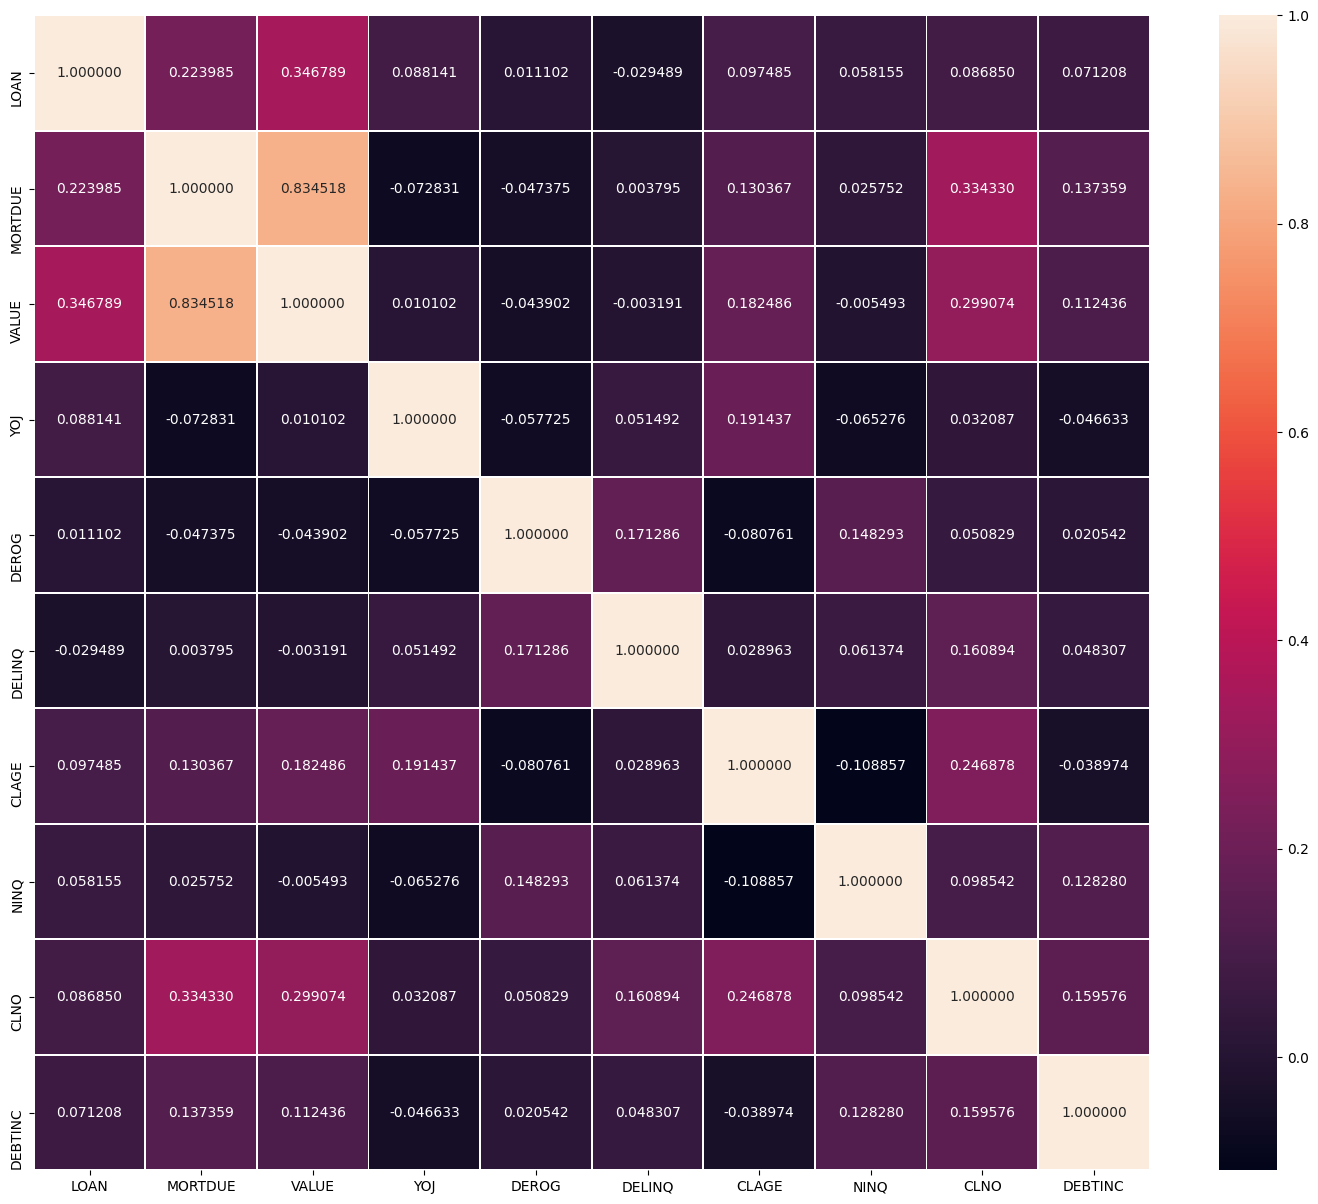

In [19]:
corr= df.select_dtypes(include=np.number).corr()
f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr ,annot=True,linewidth=.5,fmt='1f');

Due to the amount of variables, it can be hard to make sense of the plot and spot the important variable relationships. We can solve this by filtering from a specific threshold. For example, we consider a threshold of $\rho=0.3$ below, and focus the plot to those variables whose pairwise correlation exceeds this threshold.

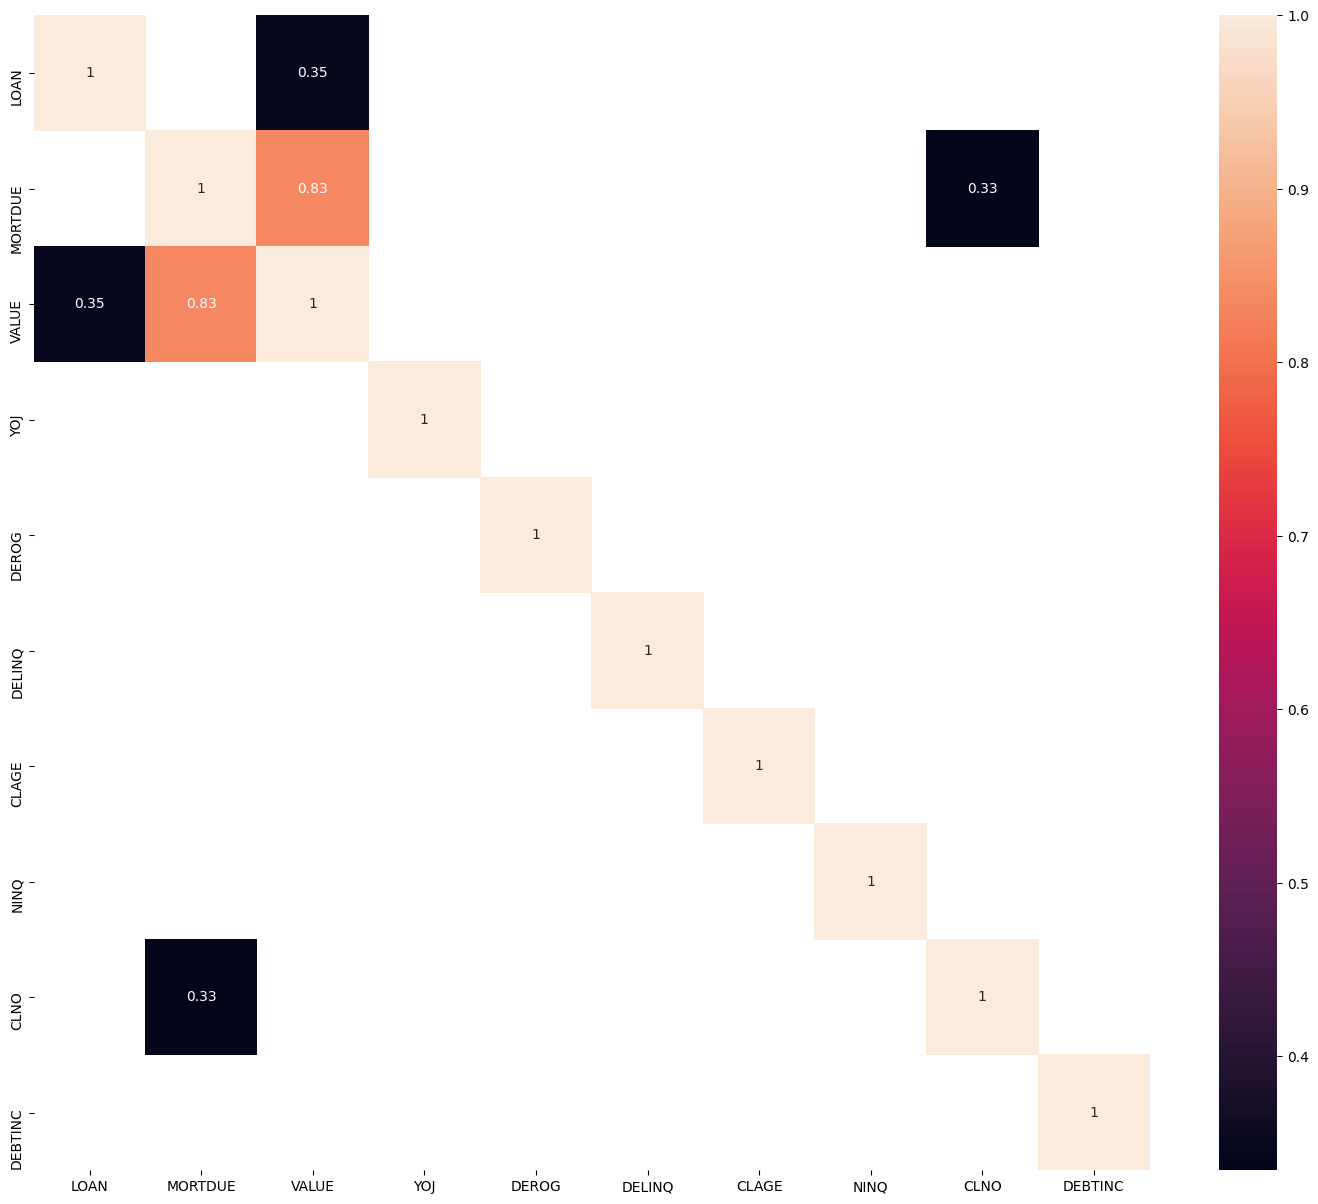

In [20]:
f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr[(corr >= 0.30) | (corr <= -0.30)],
            annot=True);

If you have trust in the threshold, the above chart makes variable selection easy.

### Multivariate analysis of categorical variables

Categories and the binary target in particular are also useful to examine sub-groups. For example, we could calculate the mean of a/all numeric variables for good and bad borrowers. Enter `.groupby()`:

In [21]:
df.groupby("BAD").mean(numeric_only=True)

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero
BAD,,,,,,,,,,,
False,18861.077342,73393.894075,102059.850918,8.951687,0.116747,0.219032,186.071036,1.016349,21.270384,33.410921,0.920981
True,16846.509672,68043.478192,94381.183188,7.966569,0.656013,1.154752,150.699531,1.677881,21.097561,36.367010,0.707317


Another standard operation when exploring categorical variables is to check cross-tabulations. Considering, for example, the variables `Reason`and `Job`, we can create a cross-tab as follows:

In [22]:
pd.crosstab(df.REASON, df.JOB)

JOB,Mgr,Office,Other,ProfExe,Sales,Self
REASON,,,,,,
DebtCon,593,647,1894,871,97,78
HomeImp,174,301,773,405,12,115


A cross-tab can be particularly informative when it includes the target variable. This way, we can spot whether certain category levels of the other (independent) variable are especially prominent with good or bad borrowers. In this use case, we would also want to switch from showing counts (as above) to showing relative frequencies. We achieve this by augmenting our call to `crosstab()` with the argument `normalize='index'`. Have a look into the [documentation of the function](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html) to understand why we select the option `'index'` for the function argument.

In [23]:
job = pd.crosstab(df.JOB, df.BAD, normalize='index')
job

BAD,False,True
JOB,,
Mgr,0.766623,0.233377
Office,0.868143,0.131857
Other,0.783652,0.216348
ProfExe,0.833856,0.166144
Sales,0.651376,0.348624
Self,0.699482,0.300518


Once again, we can also report the same information in a graphical way. A common way to display categorical variables is the stacked count plot. Let us analyze the variables `REASON` and `JOB` and how they are linked to the target variable.

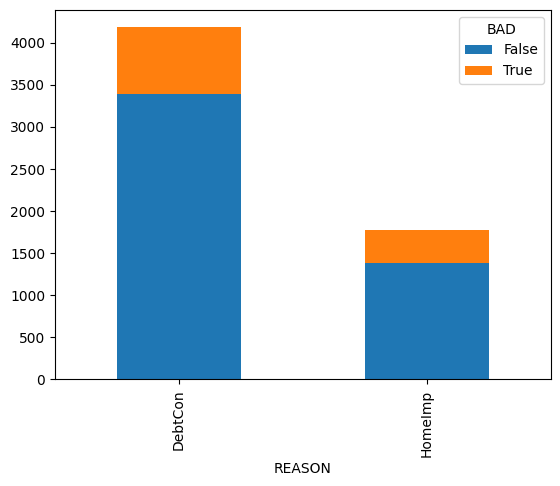

In [24]:
reason = df.groupby(['BAD', 'REASON'], observed=True).size().reset_index().pivot(columns='BAD', index='REASON', values=0)
                                                                       
reason.plot(kind='bar', stacked=True); 

Let's do it one more time, this time showing the relative frequencies instead of the absolute counts. This might provide more insight into the variable distribution and how it differs across the two target groups (i.e., goods and bads)

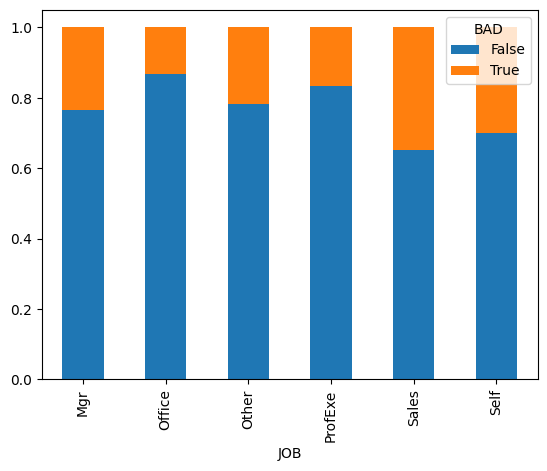

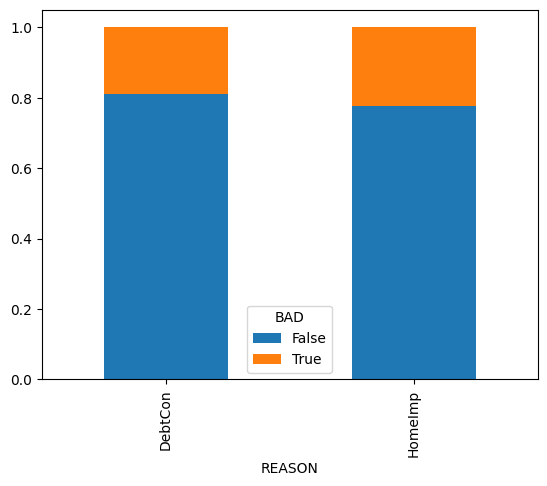

In [25]:
job.div(job.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
reason.div(reason.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True);


### Interactions between numeric and categorical variables 
Next, we can have a look at the distribution of our categories across the numerical variables. Violin plots are a great way to do so. The *seaborn* library makes creating these plots very easy. Below, we illustrate two options.

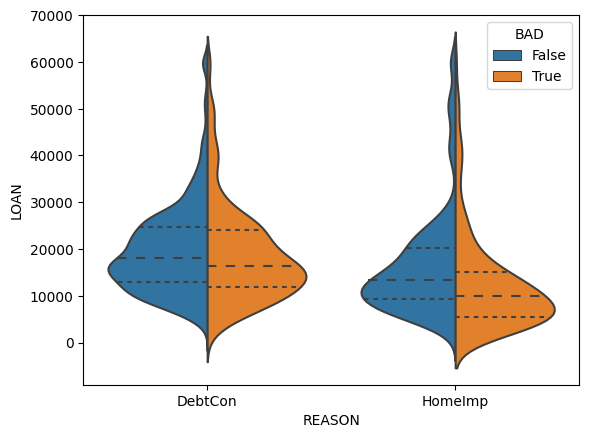

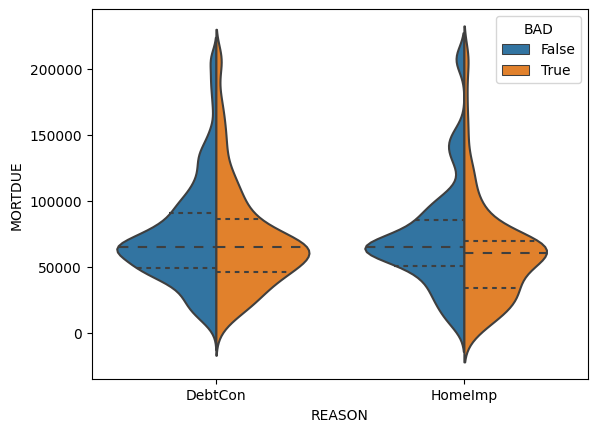

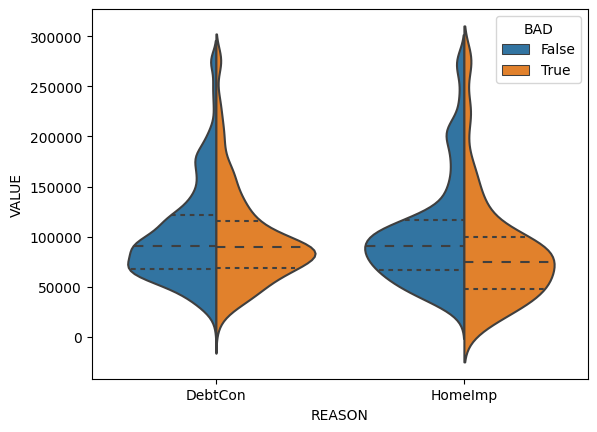

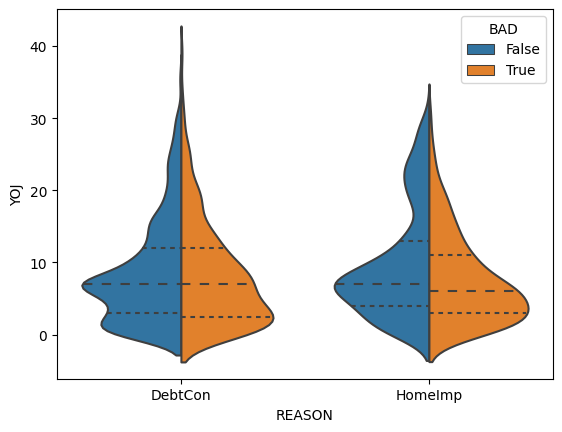

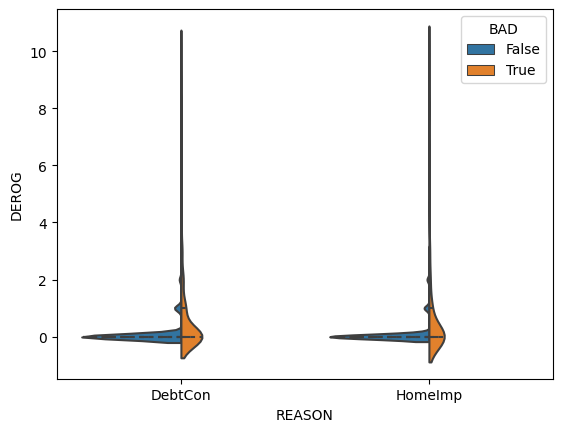

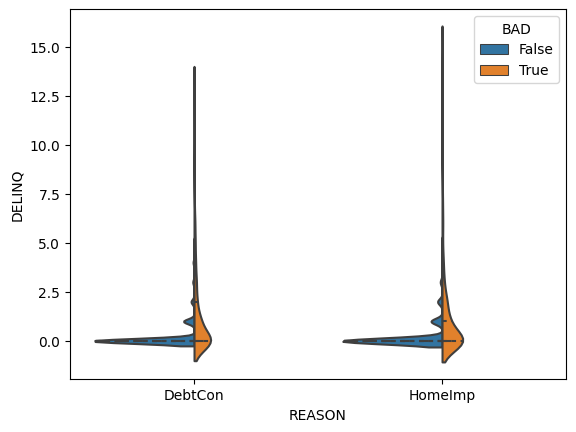

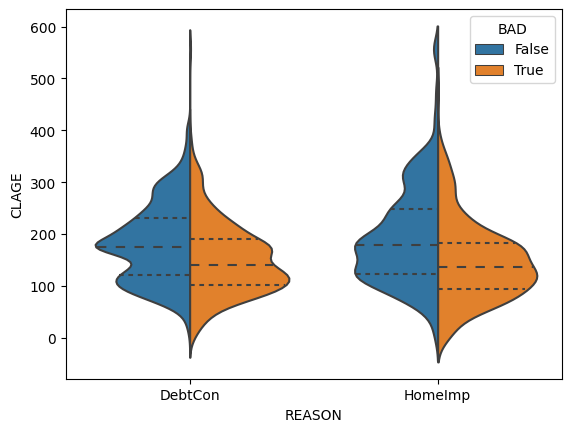

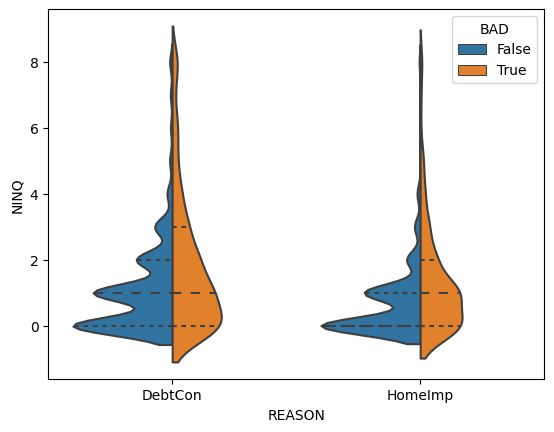

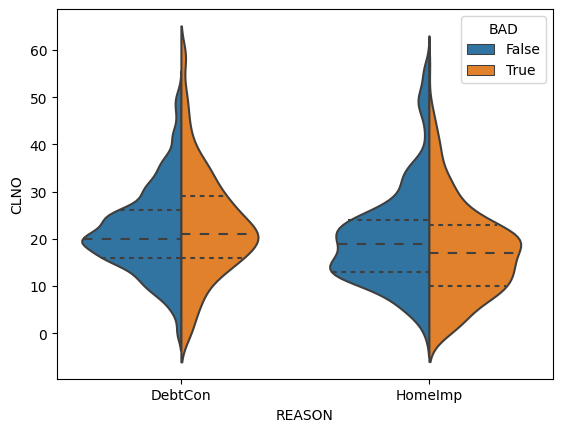

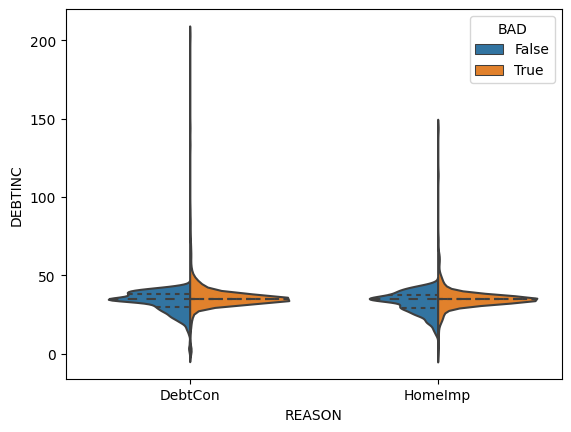

In [26]:
# We use the category 'REASON' and create one plot for each numeric variable
for col  in df.select_dtypes(include=np.number).columns:
    plt.figure()
    sns.violinplot(x='REASON', y=col, hue='BAD',
                   split=True, inner="quart",
                   data= df)
plt.show()


Let's repeat this for the variable 'JOB' but using a different approach

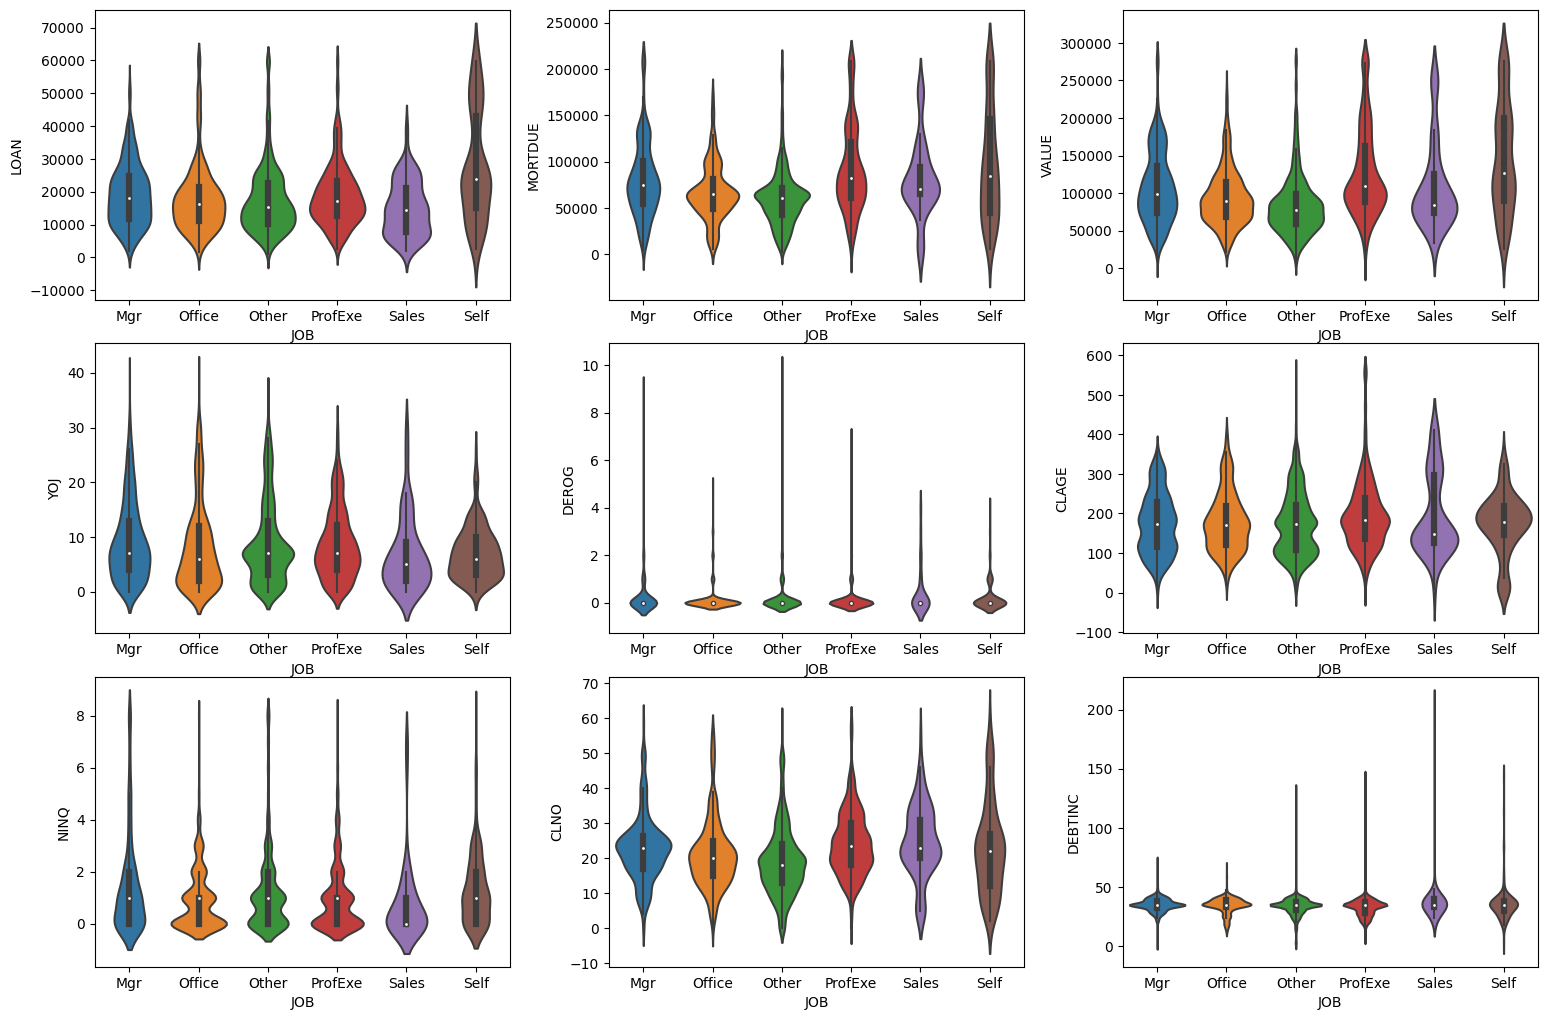

In [27]:
# Repeat for category JOB
fig, axs = plt.subplots(3,3, figsize=(15, 10))
plt.tight_layout(pad=0.5, w_pad=4, h_pad=1.0)  
x = df.JOB

sns.violinplot(x=x, y="LOAN",  data=df,ax=axs[0,0])
sns.violinplot(x=x, y="MORTDUE", data=df,ax=axs[0,1])
sns.violinplot(x=x, y="VALUE", data=df,ax=axs[0,2])
sns.violinplot(x=x, y="YOJ", data=df,ax=axs[1,0])
sns.violinplot(x=x, y="DEROG", data=df,ax=axs[1,1])
sns.violinplot(x=x, y="CLAGE", data=df,ax=axs[1,2])
sns.violinplot(x=x, y="NINQ", data=df,ax=axs[2,0])
sns.violinplot(x=x, y="CLNO", data=df,ax=axs[2,1])
sns.violinplot(x=x, y="DEBTINC", data=df,ax=axs[2,2]);

# Binary classification for PD modeling
Having prepared and explored our data, we can proceed with predictive modeling. The lecture introduced the general classification setup and the logistic regression model. Let's revisit these elements in detail. Prior to that, this is a good time to separate our data into an array $y$ containing the target variable and a data frame $X$ containing the features.

In [28]:
X = df.drop(columns=['BAD', 'DELINQ', 'DEROG'])  # drop target and the two skewed features we discretized
y = df['BAD']

## Excercise 1: Plotting data for classification
You will remember the many plots we came across when discussing regression. We also saw some analog plots for classification problems in the lecture. One of them was a 2d scatter plot displaying the bi-variate relationship between selected features and the binary target variable. 

![Classification problem in 2D](https://raw.githubusercontent.com/stefanlessmann/ESMT_IML/main/resources/2d_classification_problem.png)

Your first task is to create a similar plot for the credit data. In principle, you can select any combination of features that you like.  

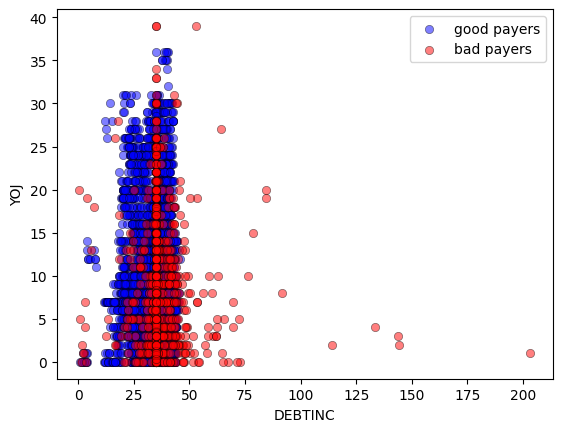

In [29]:
# Exercise 1
x1 = 'DEBTINC'  # select first feature of your choice
x2 = 'YOJ'  # select second feature of your choice

# Write code to create the scatter plot of x1 vs. x2. Make sure your plot shows the data points from different classes (good and bad payers) in different colors.
plt.scatter(X[y==0][x1], X[y==0][x2], c='blue', label="good payers", alpha=0.5, edgecolor="black", linewidth=0.5)
plt.scatter(X[y==1][x1], X[y==1][x2], c='red', label="bad payers", alpha=0.5, edgecolor="black", linewidth=0.5)
plt.legend(loc='best')
plt.xlabel(x1)
plt.ylabel(x2)
plt.show()

## Logistic regression
Time to estimate our first model. We will use logistic regression. Think of it as an extension of linear regression for cases in which we work with a binary target variable. The lecture will soon provide more details.

Just as in linear regression, logistic regression involves model training on labelled data. The below code uses the `sklearn` library to train a logistic regression-based classification model. 

### Dummy coding
Before we proceed, we need to dummy code our categorical variables. This is a standard step in classification modeling. The `get_dummies()` function from the `pandas` library is a convenient way to achieve this. 

In [30]:
X = pd.get_dummies(X, drop_first=True)  
X.info()  # Note how the function created new dummy variables in our feature matrix

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LOAN            5960 non-null   float64
 1   MORTDUE         5960 non-null   float64
 2   VALUE           5960 non-null   float64
 3   YOJ             5960 non-null   float64
 4   CLAGE           5960 non-null   float64
 5   NINQ            5960 non-null   float64
 6   CLNO            5960 non-null   float64
 7   DEBTINC         5960 non-null   float64
 8   DEROGzero       5960 non-null   bool   
 9   REASON_HomeImp  5960 non-null   uint8  
 10  JOB_Office      5960 non-null   uint8  
 11  JOB_Other       5960 non-null   uint8  
 12  JOB_ProfExe     5960 non-null   uint8  
 13  JOB_Sales       5960 non-null   uint8  
 14  JOB_Self        5960 non-null   uint8  
 15  DELINQcat_1     5960 non-null   uint8  
 16  DELINQcat_1+    5960 non-null   uint8  
dtypes: bool(1), float64(8), uint8(8)



### Model training

In [31]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(X, y)  # we define a random_state to ensure that we get the same results when re-running this cell multiple times
print(model)

LogisticRegression()


Note that the `sklearn` implementation does not provide an informative summary, as did the library `statsmodels`, which we used to [illustrate regression analysis](https://github.com/Humboldt-WI/bads/blob/master/tutorial_notebooks/4_predictive_analytics_tasks.ipynb). In brief, this is because `sklearn` is designed to support prediction. Let's demonstrate how to do this, that is compute predictions using the trained model. For simplicity, we compute prediction for the training data. You already learnt that this is inappropriate. We do it here to keep things simple. 

In [32]:
yhat = model.predict(X)  # simple way to compute predictions using logistic regression and any other machine learning model in sklearn 

Likely, you are also interested to assess the model. There is an easy way to do this:

In [33]:
perf = model.score(X, y)  # Call a general purpose evaluation function and obtain a (quality ) score of the model
print('Logit model achieves a score of {:.3f} %'.format(perf*100))

Logit model achieves a score of 80.050 %


### Exercise 2: Diagnosing predictions
A score of above 90 percent sounds very good. Actually, it is not, and your task is to find out why. Let's break it down into pieces.

#### A) What score?
Check the [sklearn documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html) to understand what kind of score the function `score()` has provided. What is it that we see?

**Your answer:** By default, the score reported is the classification accuracy, which depends on a default classification cut-off of 0.5

#### B) Is it good or is it bad?
Interpreting our score will be easier if we compare it to a baseline. But what baseline? We face a classification problem. There are two classes, good payers and bad payers, and we aim to tell these apart. Come up with a very basic strategy to solve the classification problem without using any model. Write a piece of code to calculate the performance of your super-basic strategy. 
> Hint: if you feel a bit lost, consider web searching for *dummy classifier* 

In [34]:
# Code to calculate the score of a dummy classifier
pos_frac = np.sum(y==1)/len(y)  # share of the positive class, which typically represents the minority
print('A dummy classifier that always predicts the majority class, achieves classification accuracy equal to {:.2f}%'.format(100*(1-pos_frac)))

A dummy classifier that always predicts the majority class, achieves classification accuracy equal to 80.05%


If you succeeded with the previous task, you will have found that a super-basic - stupid - classifier does as well as logistic regression. This is a devastating result. Our logistic regression classifier is just as good as a naive classifier, which always predicts the majority class. Put differently, the logistic regression *appears* completely useless.

Note that our approach to compute the score of the naive classifier assumes that the positive class with $Y=1$ is the minority class. While this is typically the case, we should acknowledge that our approach is simplistic. It would be better to first establish which of the two classes is the majority class and to then use the fraction of that class as the accuracy score of a dummy classifier. While not too difficult, we leave this extension for the interested to perform and move on with probabilities. 

#### C) What about probabilities?
Exactly, what about probabilities? The lecture introduced classification as a machine learning setup aimed at predicting class membership probabilities. So logistic regression should answer questions such as "what is the estimated probability of the first credit applicant in our data set to repay?"

In [35]:
# Write code to print the prediction of logistic regression for the first data point in our matrix X
yhat = model.predict(X)
print(yhat[0])

False


Solving the above task, you will find that the prediction does not look like a probability. Examine this point in more detail. To that end, write code that tells you what *distinct* values logistic regression predicts. Put differently, your code should print out all unique values that logistic regression has predicted across all data points. 

Briefly explain your result.

In [36]:
# Code to find out the distinct values of the predictions
np.unique(yhat)

array([False])

**What is the meaning of the predictions? Briefly explain.**

So the function `predict()` produces discrete class predictions. It outputs only the values with which the classes were encoded, that is either zero for class *good payer* or 1 for class *bad payer*. However, as shown using the function `numpy.unique()`, our logisitic regression only predicts class 0 and never predicts class 1.

Finally, we come back to the innocent question asked before, "what is the estimated probability of the first credit applicant in our data set to repay?". Given our previous analysis has not answered this question it is about time to. Write code to find out the estimated probability of the first applicant to be a bad credit risk?

Just in case, mathematically, we could represent the sought probability as $\hat{p}(BAD==1|X_1)$.

In [37]:
# Code to obtain probability predictions from the logit model
yhat_prob = model.predict_proba(X)
yhat_prob[0:5]

array([[0.65065979, 0.34934021],
       [0.70636491, 0.29363509],
       [0.72188499, 0.27811501],
       [0.76089499, 0.23910501],
       [0.67591043, 0.32408957]])

### Visualizing the logistic regression

#### Exercise 3: One more logistic regression
Please estimate a second logistic regression model. This time, use only two features. Exercise 1 has asked you to examine combinations of features. Just continue with the two features you selected there. 

In [38]:
print('Our first feature is:\t', x1)
print('Our second feature is:\t', x2)

Our first feature is:	 DEBTINC
Our second feature is:	 YOJ


In [39]:
# Write code to estimate a logistic regression classifier using only the two above features
model2 = LogisticRegression(random_state=888).fit(X[[x1, x2]], y)

#### The visual logistic regression
As you will have guessed, the point of the above exercise 4 was only to obtain a logistic regression model that we can plot; hence the need to select two features. 
The visualization is somewhat complex. Thus, all code is readily available for you. Below we provide a function `plot_logit_decision_surface()`. 
**Do not be put off by the length of the code.** You are not supposed to look through the function at this point. Of course you can, but do not allow it to confuse you. It is a function to create a plot. That is all you need to know for now. Please execute the cell to make sure you can use the function in the next exercise. 

In [40]:
def plot_logit_decision_surface(model, data, x1, x2, save_fig=False):
    '''
        Visualization of logistic regression in 2D
        
        Creates a plot depicting the distribution of the input
        data along two dimensions and the probability predictions
        of a logistic regression model. 

        Parameters
        ----------
        model :   An instance of the sklearn class LogisticRegression,  which        
                  has been trained on the input data.

        data  :   Pandas data frame providing the feature values.

        x1, x2:   The function plots the results of logistic regression in
                  two dimensions. The parameters x1 and x2 give the names
                  of the features used for plotting. These features will be
                  extracted from the data frame.

        save_fig: Binary variable allowing you to save the figure as a PNG image. 
                  Default: False

        Returns
        ----------
        The function does not return a result. It's purpose is to visualize 
        logistic regression model. The corresponding plot is the only output.
    '''

    #if len(model.coef_.ravel())!=2:
    #    raise Exception('Please estimate a logit model using only two features!')
    # Define some variables to govern the plot
    bounds = data.describe().loc[["min", "max"]][[x1, x2]].to_numpy()  # value ranges of the two features
    eps = 5  # tolerance parameter 

    # Create hypothetical data points spanning the entire range of feature values.
    # We need these to get from our logistic regression model a probability prediction
    # for every possible data point
    xx, yy = np.mgrid[(bounds[0,0]-eps):(bounds[1,0]+eps), (bounds[0,1]-eps):(bounds[1,1]+eps)]
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Perhaps the logistic regression model was fitted using the full data frame. 
    # To also work in that case, we extract the estimated regression coefficients 
    # corresponding to the two features we consider for plotting
    feature_to_index = {name: idx for idx, name in enumerate(model.feature_names_in_)}  # create a dic as intermediate step
    indices = [feature_to_index[f] for f in [x1, x2]]  # Find the indices of our two features of interest using the dic
    w = model.coef_.ravel()[indices]  # estimated regression coefficients
    b = model.intercept_  # estimated intercept of the logistic regression model

    # Compute probability predictions over the entire space of possible feature values
    # In the interest of robustness, we manually compute the logistic regression predictions
    # using the regression coefficients extracted above
    probs = 1/(1+np.exp(-(np.dot(grid, w.reshape(2,-1))+b))).reshape(xx.shape)

    # We are finally ready to create our visualization
    f, ax = plt.subplots(figsize=(8, 6))  # new figure
    # Contour plot of the probability predictions across the entire feature range
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)  
    ax_c = f.colorbar(contour)
    ax_c.set_label("$\hat{p}(y=1|X)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    # Scatter plot of the actual data
    ax.scatter(data[x1], data[x2], c=y, s=50, cmap="RdBu", vmin=0, vmax=1,
               edgecolor="white", linewidth=1);
    plt.xlabel(x1)
    plt.ylabel(x2)
    if save_fig==True:
        plt.savefig('logit_contour.png')
    plt.show()

#### Exercise 4: Surface plot
We are almost ready. Also run the next cell, which will give you some instructions on how to use the plotting function. Note that this code also works for other functions. Just put a '?' in front of a function call and run the code. 

In [43]:
help(plot_logit_decision_surface)

Help on function plot_logit_decision_surface in module __main__:

plot_logit_decision_surface(model, data, x1, x2, save_fig=False)
    Visualization of logistic regression in 2D
    
    Creates a plot depicting the distribution of the input
    data along two dimensions and the probability predictions
    of a logistic regression model. 
    
    Parameters
    ----------
    model :   An instance of the sklearn class LogisticRegression,  which        
              has been trained on the input data.
    
    data  :   Pandas data frame providing the feature values.
    
    x1, x2:   The function plots the results of logistic regression in
              two dimensions. The parameters x1 and x2 give the names
              of the features used for plotting. These features will be
              extracted from the data frame.
    
    save_fig: Binary variable allowing you to save the figure as a PNG image. 
              Default: False
    
    Returns
    ----------
    The function 

I guess your next task is obvious. Write code to call the function providing the necessary parameters so that it can do its job. If used correctly, the function will create a plot like this one:
![Contour plot of logistic regression model](https://raw.githubusercontent.com/stefanlessmann/ESMT_IML/main/resources/logit_contour.png)

Let's if it works for you...

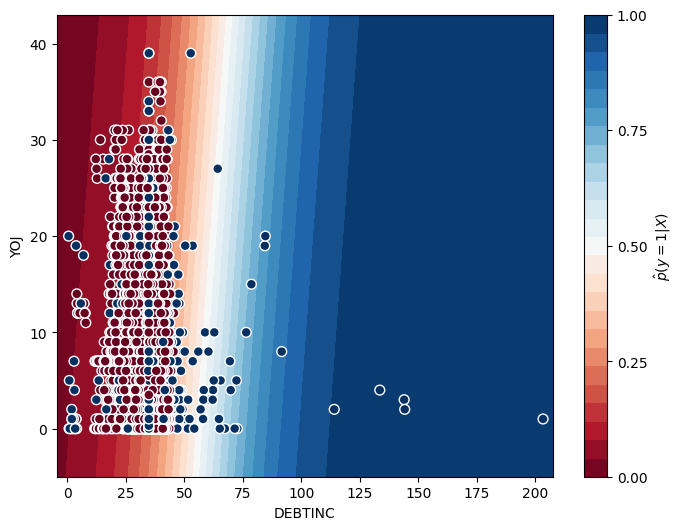

In [42]:
# Code to call the function plot_logit_decision_surface()
plot_logit_decision_surface(model2, X, x1, x2)

# Well done! This was another comprehensive set of exercises.